In [2]:
#Import Packages

import numpy as np
from numpy import random as rd
from pykrx import stock
import scipy as sp
import pandas as pd
from scipy import optimize
import copy
import matplotlib.pyplot as plt

In [80]:
class DataManager:
    def __init__(self):
        self.data = None # pd.DF
        self.ret = None
        self.tickers = None
        self.ret = None
        self.N = None
        
    def setTickers(self, tickers):
        self.tickers = tickers
        self.N = len(self.tickers)
            
    def createRet(self):
        for i in range(1, self.data.shape[0]):
            self.ret.iloc[i] = self.data.iloc[i]/self.data.iloc[i-1]

    def loadData(self, srt, end):
        if type(srt) == str:
            srt = srt
        else:
            srt = str(srt)
        if type(end) == str:
            end = end
        else:
            end = str(end)
        raw_data = []
        N = self.N
        for i in range(N):
            raw_data.append(stock.get_market_ohlcv_by_date(srt, end, self.tickers[i])["종가"])
        self.data = pd.DataFrame(np.asarray(raw_data).T, columns = self.tickers, dtype=np.int32)
        self.ret = pd.DataFrame(np.nan, index=np.arange(self.data.shape[0]), columns=self.data.columns)
        self.createRet()
        
    def get_ret(self):
        return self.ret.iloc[1:]
    

In [169]:
class Optima:
    def __init__(self):
        self.var_cov_mat = None
        self.rf = 0.015
        self.N = None
        self.data = None
        self.tp = None # time Point
        self.windowLength = None
        
    def loadData(self, data): #이때 받아오는 데이터는 ret이다.
        self.data = data
        self.N = data.shape[1]
        self.var_cov_mat = np.identity(self.N)#var cov mat init
    
    def gen_var_cov_mat(self):
        ret_tp = self.data.iloc[self.tp - self.windowLength : self.tp]
        for i in range(0, self.N):
            for j in range(0, self.N):
                self.var_cov_mat[i][j] = np.cov(ret_tp.iloc[1:,i], ret_tp.iloc[1:,j])[0,1]
    
    def setWindowLength(self, time):
        self.windowLength = time
    
    def setTimePoint(self, tp):
        self.tp = tp

###################################################################################################
###################################################################################################

    def eq_constraint(self, w):
        summation = 0
        for i in w:
            summation += i
            
        return summation - 1
    
    def flarray(self, w): #수익률도 전체 데이터가 아닌 특정기간의 수익률로 바꿔줘야함!!!!!
        ret_exd = np.cumprod(self.data.iloc[self.tp - self.windowLength : self.tp]) - self.rf
        return -(np.dot(np.transpose(ret_exd.iloc[-1]), w) / (np.dot(np.dot(np.transpose(w), self.var_cov_mat), w))**(1/2))

    def Max_Sharp(self):
        return sp.optimize.fmin_slsqp(self.flarray, [1/self.N for i in range(self.N)], bounds=[(0,1) for i in range(self.N)], eqcons=[self.eq_constraint])

###################################################################################################
###################################################################################################
    
    def w(self):
        self.gen_var_cov_mat()
        print(self.var_cov_mat)
        return self.var_cov_mat
        return self.Max_Sharp()
    
    
    
    

In [171]:
tickers = ["002810", "003920", "004380", "011280"]#, "016580", "007340", "000370", "001510", "033270", "004710", "001500"]

optima = Optima()
dm = DataManager()

dm.setTickers(tickers)
dm.loadData(20190101, 20191231)

optima.loadData(dm.get_ret())

optima.setWindowLength(30)
optima.setTimePoint(30)
result = optima.w()

[[ 3.95420746e-04  4.24401444e-05 -1.11182053e-04  5.10579010e-05]
 [ 4.24401444e-05  1.61396030e-04 -7.62609469e-06  2.63154003e-05]
 [-1.11182053e-04 -7.62609469e-06  1.22167931e-03  6.51105394e-05]
 [ 5.10579010e-05  2.63154003e-05  6.51105394e-05  5.81156122e-04]]


In [124]:
pd.DataFrame((result for i in range(10)))

,0,1,2,3
0,0.230405,0.513425,0.127093,0.129077
1,0.230405,0.513425,0.127093,0.129077
2,0.230405,0.513425,0.127093,0.129077
3,0.230405,0.513425,0.127093,0.129077
4,0.230405,0.513425,0.127093,0.129077
5,0.230405,0.513425,0.127093,0.129077
6,0.230405,0.513425,0.127093,0.129077
7,0.230405,0.513425,0.127093,0.129077
8,0.230405,0.513425,0.127093,0.129077
9,0.230405,0.513425,0.127093,0.129077


In [118]:
wwwww=pd.DataFrame(([1 for i in range(rebal.shape[1])] for i in range(rebal.shape[0])))
wwwww.iloc[1:20] = pd.DataFrame(([99, 20, 20, 20 , 20] for i in range(200)))
wwwww.head(30)

,0,1,2,3,4
0,1,1,1,1,1
1,99,20,20,20,20
2,99,20,20,20,20
3,99,20,20,20,20
4,99,20,20,20,20
5,99,20,20,20,20
6,99,20,20,20,20
7,99,20,20,20,20
8,99,20,20,20,20
9,99,20,20,20,20


In [135]:
w_init=[1/4,1/4,1/4,1/4]

In [172]:
ww=pd.DataFrame(([1 for i in range(4)] for i in range(rebal.shape[0])))
ww.iloc[0*fr : 1*fr] = pd.DataFrame((w_init for i in range(fr)))
print('hi')
for i in range((rebal.shape[0]//fr)):
    optima.setTimePoint((i+1)*fr)
    if i == (rebal.shape[0]//fr)-1 :#마지막일때
        #optima.setTimePoint(100)
        result = optima.w()
        
        print(result)
        #ww.iloc[(rebal.shape[0]//fr)*fr : ] = pd.DataFrame((result for i in range(fr)))
    else:
        #ww.iloc[(i+1)*fr:(i+2)*fr] = pd.DataFrame((result for i in range(fr)))
        pass
#ww

hi
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


/Users/yongcheolkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Degrees of freedom <= 0 for slice


In [129]:
class PerformanceAnalyzer:
    def __init__(self,data , optima):
        self.freq = None
        self.data = data
        self.optima = optima
        
    
    def visualize(self, freq):
        fr = freq
        rebal = self.data
        w_init_rebal = rebal.iloc[0:fr]
        rebal = rebal.iloc[fr:]
        #w init 구하기
        self.optima.setWindowLength(fr)
        self.optima.setTimePoint(fr)
        w_init = self.optima.w()
        
        scalar = pd.DataFrame(index=range(0,rebal.shape[0]//fr+1))
        scalar['k'] = 1
        
        #일단 w값부터 모두 구하자.
        ww=pd.DataFrame(([1 for i in range(rebal.shape[1])] for i in range(rebal.shape[0])))
        ww.iloc[0*fr : 1*fr] = pd.DataFrame((w_init for i in range(fr)))
        for i in range((rebal.shape[0]//fr)):
            self.optima.setTimePoint((i+1)*fr)
            if i == (rebal.shape[0]//fr)-1 :#마지막일때
                ww.iloc[(rebal.shape[0]//fr)*fr : ] = pd.DataFrame((self.optima.w() for i in range(fr)))
            else:
                ww.iloc[(i+1)*fr:(i+2)*fr] = pd.DataFrame((self.optima.w() for i in range(fr)))

            
        cumprod_DF = copy.deepcopy(rebal)
        
        #리밸런싱 기간씩 끊어서 cumprod를 구해줌.
        for i in range((rebal.shape[0]//fr)):#fr = 4 , range(0,2)
            cumprod_DF.iloc[i*fr:(i+1)*fr] = rebal.iloc[i*fr :(i+1)*fr].cumprod()
            if i != 0:#스칼라도 똑같이 해주는데, 첫번째 이터레이션에서는 초기값 1로 고정. 따라서 i==0일때 상위 포문 넘어감.
                #이것도 실제로는 동일비중이 아니라, 특정 w벡터로 나눠줘야함.
                scalar['k'].iloc[i] = cumprod_DF.iloc[i*fr - 1].sum()/cumprod_DF.shape[1]

        if rebal.shape[0]%fr != 0:
            mok = rebal.shape[0]//fr
            scalar['k'].iloc[-1 ] = cumprod_DF.iloc[(mok)*fr -1 ].sum()/cumprod_DF.shape[1]
            cumprod_DF.iloc[mok*fr : ] = rebal.iloc[mok*fr:].cumprod()
        ############
        ############
        scalars = pd.DataFrame(index=range(0,rebal.shape[0]), columns=range(0,rebal.shape[1]))
        for i in range(rebal.shape[0]//fr):
            scalars[0].iloc[i*fr : i*fr+fr] = scalar.cumprod().iloc[i][0]#float(scalar.iloc[i]) * float(scalar.iloc[i-1])
            if i == 0:
                scalars[0].iloc[i*fr : i*fr+fr] = 1

        if rebal.shape[0]%fr != 0:#32개 중 마지막 2개에 대 한 처리
            mok = rebal.shape[0]//fr
            scalars[0].iloc[(mok)*fr : ] = scalar.cumprod().iloc[-1][0]#float(scalar.iloc[-1])*float(scalar.iloc[-2])

        for i in range(1,rebal.shape[1]):
            scalars[i] = scalars[i-1]


        (ww * cumprod_DF * scalars).sum(axis=1)

        plt.figure()
        plt.plot((ww * cumprod_DF * scalars).sum(axis=1), c='g')
        #plt.plot((ww*cumprod_DF).sum(axis=1))
        #리밸런싱을 안하면 cumprod_DF를 쓰는게 아니라 그냥 cumprod(testdf)하면 되는 거였음.
        plt.plot(rebal.cumprod().sum(axis=1)/rebal.shape[1], c='r')
        plt.show()

In [130]:
ww

,0,1,2,3,4
0,0.2,0.2,0.2,0.2,0.2
1,0.2,0.2,0.2,0.2,0.2
2,0.2,0.2,0.2,0.2,0.2
3,0.2,0.2,0.2,0.2,0.2
4,0.2,0.2,0.2,0.2,0.2
...,...,...,...,...,...
328,0.2,0.2,0.2,0.2,0.2
329,0.2,0.2,0.2,0.2,0.2
330,0.2,0.2,0.2,0.2,0.2
331,0.2,0.2,0.2,0.2,0.2


In [69]:
rebal = pd.DataFrame(([1+np.random.randint(-10,13)*0.0051 for i in range(5)] for i in range(333)))


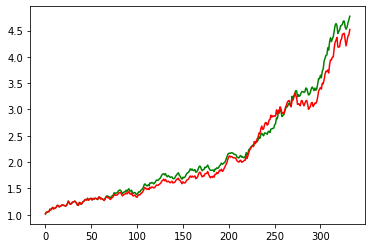

In [72]:
fr = 60
scalar = pd.DataFrame(index=range(0,rebal.shape[0]//fr+1))
scalar['k'] = 1

cumprod_DF = copy.deepcopy(rebal)

for i in range((rebal.shape[0]//fr)):#fr = 4 , range(0,2)
    cumprod_DF.iloc[i*fr:(i+1)*fr] = rebal.iloc[i*fr :(i+1)*fr].cumprod()
    if i != 0:
        #이것도 실제로는 동일비중이 아니라, 특정 w벡터로 나눠줘야함.
        scalar['k'].iloc[i] = cumprod_DF.iloc[i*fr - 1].sum()/cumprod_DF.shape[1]

if rebal.shape[0]%fr != 0:
    mok = rebal.shape[0]//fr
    scalar['k'].iloc[-1 ] = cumprod_DF.iloc[(mok)*fr -1 ].sum()/cumprod_DF.shape[1]
    cumprod_DF.iloc[mok*fr : ] = rebal.iloc[mok*fr:].cumprod()
############
############
scalars = pd.DataFrame(index=range(0,rebal.shape[0]), columns=range(0,rebal.shape[1]))
for i in range(rebal.shape[0]//fr):
    scalars[0].iloc[i*fr : i*fr+fr] = scalar.cumprod().iloc[i][0]#float(scalar.iloc[i]) * float(scalar.iloc[i-1])
    if i == 0:
        scalars[0].iloc[i*fr : i*fr+fr] = 1

if rebal.shape[0]%fr != 0:#32개 중 마지막 2개에 대 한 처리
    mok = rebal.shape[0]//fr
    scalars[0].iloc[(mok)*fr : ] = scalar.cumprod().iloc[-1][0]#float(scalar.iloc[-1])*float(scalar.iloc[-2])

for i in range(1,rebal.shape[1]):
    scalars[i] = scalars[i-1]

ww=pd.DataFrame(([1/rebal.shape[1] for i in range(rebal.shape[1])] for i in range(rebal.shape[0])))

(ww * cumprod_DF * scalars).sum(axis=1)

plt.figure()
plt.plot((ww * cumprod_DF * scalars).sum(axis=1), c='g')
#plt.plot((ww*cumprod_DF).sum(axis=1))
#리밸런싱을 안하면 cumprod_DF를 쓰는게 아니라 그냥 cumprod(testdf)하면 되는 거였음.
plt.plot(rebal.cumprod().sum(axis=1)/rebal.shape[1], c='r')
plt.show()

In [71]:
scalar#.cumprod()

,k
0,1.000000
1,1.334647
2,1.198567
3,1.165147
4,1.369831
5,1.404607


,0,1,2,3,4
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,1,1,1
8,1,1,1,1,1
9,1,1,1,1,1


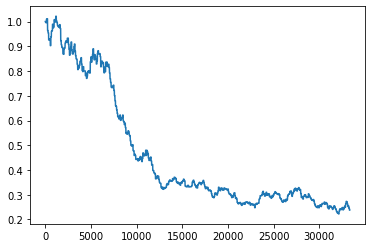

In [46]:
plt.figure()
plt.plot(scalars[0])
plt.show()

In [430]:
(ww * cumprod_DF * scalars).sum(axis=1).iloc[-1]

4.9807235967387635

In [434]:
rebal.cumprod().sum(axis=1).iloc[-1]/6

4.909872591776103

In [5]:
mdd = pd.DataFrame(([rd.randint(-5, 8)*0.01 + 1 for i in range(100)]))
#mdd = pd.DataFrame([1,2,3,4,2,3,4,5,1,2,6])
mdd = mdd.cumprod()

In [7]:
newhigh = copy.deepcopy(mdd)
for i in range(1, mdd.shape[0]):
    newhigh.iloc[i] = max(mdd.iloc[i][0], mdd.iloc[0:i].max()[0])

In [8]:
mdd.iloc[0:3].max()[0]

0.9875250000000001

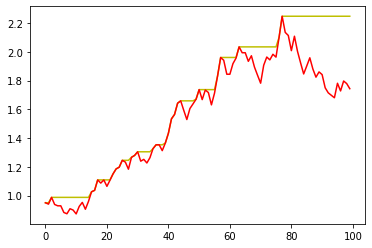

In [9]:
plt.figure()
plt.plot(newhigh, c='y')
plt.plot(mdd, c='r')
plt.show()

In [10]:
maxdrawdown = - newhigh + mdd

0   -0.567247
dtype: float64


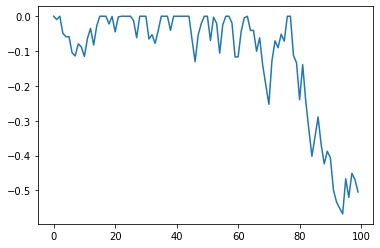

In [13]:
plt.plot(maxdrawdown)
print(maxdrawdown.min())

In [492]:
scalars

,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
484,0.924381,0.924381,0.924381,0.924381
485,0.924381,0.924381,0.924381,0.924381
486,0.924381,0.924381,0.924381,0.924381
487,0.924381,0.924381,0.924381,0.924381


In [480]:
cumprod_DF

,0,1,2,3
1,0.967015,0.995733,1.161215,0.998012
2,0.964246,0.992888,1.133178,0.994036
3,0.950462,0.984353,1.144860,0.998012
4,0.934031,0.974395,1.088785,0.994036
5,0.939508,0.970128,1.119159,0.990060
...,...,...,...,...
485,1.034576,1.005917,1.008772,0.969484
486,1.043994,1.031953,0.995614,0.962441
487,1.047155,1.024852,1.008772,1.007042
488,1.057034,1.020118,1.026316,1.022300


# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#

In [39]:
testdf.iloc[0:2].sum(axis = 1)

0    6.03
1    6.11
dtype: float64

In [222]:
freq = 10
w = [1/5, 1/5, 1/5, 1/5, 1/5]

In [239]:
rebal.shape[0]%freq

8

In [243]:
a = np.asarray([1,2,3])
b = np.asarray([1,2,3])
a*b

array([1, 4, 9])

In [242]:
for i in range((rebal.shape[0]//freq)):
    df = rebal.iloc[i*freq :(i+1)*freq]
    print(df)
    
if rebal.shape[0]%freq != 0:
    print(rebal.iloc[-(rebal.shape[0]%freq):])


      0     1     2     3     4     5
0  1.02  0.93  0.95  0.99  1.02  0.95
1  1.05  0.94  1.05  1.11  1.11  1.03
2  0.97  1.05  0.98  1.02  0.99  1.04
3  0.90  0.99  1.09  1.11  1.08  0.97
4  0.96  1.03  0.97  1.01  0.99  1.10
5  0.95  1.08  0.94  0.90  0.90  1.00
6  0.92  1.07  0.97  1.08  1.06  0.99
7  0.99  1.09  1.10  1.07  0.94  1.11
8  0.99  1.01  1.07  0.97  0.98  0.97
9  1.01  1.03  1.08  1.06  1.04  0.97
       0     1     2     3     4     5
10  1.09  0.93  1.03  1.07  1.01  0.94
11  0.97  1.04  1.02  0.91  0.91  1.04
12  0.93  1.09  0.93  0.91  0.97  1.00
13  1.04  0.97  1.00  1.06  1.03  1.05
14  1.01  0.90  0.98  1.01  1.02  0.91
15  0.99  0.90  1.05  1.08  1.01  1.08
16  1.04  0.91  1.04  0.98  0.96  0.93
17  1.00  1.07  1.10  0.93  0.96  0.94
18  1.11  1.10  0.97  0.98  0.92  0.91
19  1.06  1.02  0.92  1.03  1.07  1.09
       0     1     2     3     4     5
20  0.93  0.98  1.00  1.01  1.07  0.90
21  1.11  0.95  1.08  0.95  1.11  0.94
22  0.93  0.95  0.96  0.98  1.00  1.

In [120]:
rebal.iloc[5:10].cumprod()

,0,1,2,3,4,5
5,1.060000,1.100000,0.910000,1.04000,0.960000,1.000000
6,1.134200,1.133000,0.819000,0.98800,0.892800,0.940000
7,1.100174,1.178320,0.794430,1.07692,0.964224,0.921200
8,1.045165,1.225453,0.714987,1.07692,0.896728,0.985684
9,1.076520,1.127417,0.779336,1.07692,0.941565,0.965970


In [119]:
rebal.iloc[1:5].cumprod()

,0,1,2,3,4,5
1,1.070000,0.900000,0.900000,1.020000,1.030000,0.900000
2,0.984400,0.882000,0.810000,0.948600,0.999100,0.819000
3,1.092684,0.943740,0.801900,1.033974,1.059046,0.761670
4,1.212879,0.972052,0.745767,0.982275,1.016684,0.845454


In [121]:
rebal.head(11)

,0,1,2,3,4,5
0,1.00,0.94,0.94,1.02,0.94,1.05
1,1.02,1.02,1.02,1.04,1.07,0.97
2,1.08,0.99,0.96,1.03,1.02,1.05
3,1.09,0.91,1.01,0.94,0.95,0.96
4,1.05,0.97,0.92,0.99,1.09,1.04
5,1.11,1.05,0.93,1.02,1.00,1.09
6,0.92,1.03,1.11,1.04,1.09,1.07
7,1.05,1.05,0.91,1.09,1.08,0.93
8,0.90,1.07,0.91,0.91,1.09,0.93
9,0.97,1.10,1.00,0.94,0.97,1.11


In [34]:
pd.DataFrame.cumsum(rebal.cumprod().iloc[-1])[-1:]/5

5    1.617605
Name: 111, dtype: float64

In [134]:
rebal.cumprod().iloc[-1]

0    3.541576
1    0.591426
2    0.583374
3    1.051113
4    4.484368
5    1.611752
Name: 99, dtype: float64

In [205]:
aaaa = pd.DataFrame(([1,2,3],[2,2,5],[3,2,2]))

In [206]:
aaaa

,0,1,2
0,1,2,3
1,2,2,5
2,3,2,2


In [207]:
aaaa.cumprod()

,0,1,2
0,1,2,3
1,2,4,15
2,6,8,30


In [208]:
aaaa.cumprod().sum(axis=1)

0     6
1    21
2    44
dtype: int64

In [211]:
aaaa.sum(axis=1)

0    6
1    9
2    7
dtype: int64